In [12]:
!pip install jiwer editdistance

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
# ----- CTC Transcription Tokenizer -----
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from jiwer import wer, cer
import matplotlib.pyplot as plt
import numpy as np
import time

In [43]:
# Define vocabulary
vocab = list("abcdefghijklmnopqrstuvwxyz '") + ['|']
char_to_index = {c: i for i, c in enumerate(vocab)}
index_to_char = {i: c for c, i in char_to_index.items()}
blank_index = char_to_index['|']

# Clean transcription
def clean_transcription(text):
    if not isinstance(text, str):
        return None
    text = text.lower().strip()
    if '.jpg' in text or '[say' in text or text == 'xxx' or text == '':
        return None
    return text

# Decode sequence to text
def decode_sequence(indices):
    return ''.join([index_to_char.get(i, '') for i in indices]).replace('|', '').strip()

# Dataset to load preprocessed mel spectrograms
class PrecomputedMelDataset(Dataset):
    def __init__(self, mel_dir):
        self.paths = sorted([
            os.path.join(mel_dir, f) for f in os.listdir(mel_dir)
            if f.endswith('.pt')
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        mel_path = self.paths[idx]
        mel_spec, transcript = torch.load(mel_path)

        clean = clean_transcription(transcript)
        if clean is None:
            return None

        # Skip very long sequences
        if mel_spec.size(0) > 3000:
            return None

        target = torch.tensor([char_to_index[c] for c in clean if c in char_to_index], dtype=torch.long)
        return mel_spec, target

# Collate function
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if not batch:
        return None

    specs, targets = zip(*batch)
    lens = torch.tensor([s.size(0) for s in specs], dtype=torch.long)
    tgt_lens = torch.tensor([t.size(0) for t in targets], dtype=torch.long)

    specs_padded = pad_sequence(specs, batch_first=True).transpose(1, 2)  # [B,80,T]
    targets_flat = torch.cat(targets)

    return specs_padded, targets_flat, lens, tgt_lens

In [44]:
# CTC-based Transcription Tokenizer Model
class CTCTranscriptionTokenizer(nn.Module):
    def __init__(self, input_dim=80, hidden_dim=128, vocab_size=len(vocab)):
        super().__init__()
        # Simple bidirectional LSTM model
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)

    def forward(self, x):
        x = x.transpose(1, 2)  # [B,T,80]
        out, _ = self.lstm(x)
        return self.fc(out)

# Beam Search Decoder
class BeamSearch:
    def __init__(self, beam_width=5, blank_index=blank_index):
        self.beam_width = beam_width
        self.blank = blank_index

    def decode(self, logits):
        batch_size, T, V = logits.size()
        log_probs = F.log_softmax(logits, dim=-1)
        results = []

        for b in range(batch_size):
            beams = [([], 0.0)]  # (sequence, score)

            for t in range(T):
                new_beams = []

                for seq, score in beams:
                    # Add blank (continue with same sequence)
                    new_beams.append((seq, score + log_probs[b, t, self.blank].item()))

                    # Try adding other characters
                    values, indices = log_probs[b, t].topk(self.beam_width)
                    for i in range(len(values)):
                        idx = indices[i].item()
                        if idx != self.blank:
                            new_beams.append((seq + [idx], score + values[i].item()))

                # Sort by score and keep top beams
                beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:self.beam_width]

            results.append(beams[0][0])  # Take best beam's sequence

        return results

In [45]:
def train_tokenizer(model, train_loader, val_loader, test_loader, device, epochs=20, lr=1e-3, patience=5):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CTCLoss(blank=blank_index, zero_infinity=True)
    beam_decoder = BeamSearch()

    # Expanded tracking metrics
    history = {
        'train_loss': [], 'val_loss': [], 'test_loss': [],
        'train_wer': [], 'val_wer': [], 'test_wer': [],
        'train_cer': [], 'val_cer': [], 'test_cer': [],
        'learning_rate': [], 'epoch_time': []
    }
    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(epochs):
        epoch_start = time.time()

        # Training
        model.train()
        train_loss = 0.0
        train_wer_total = 0.0
        train_cer_total = 0.0
        batch_count = 0

        for batch in train_loader:
            if batch is None:
                continue

            specs, targets, spec_lens, target_lens = batch
            specs, targets = specs.to(device), targets.to(device)
            spec_lens, target_lens = spec_lens.to(device), target_lens.to(device)

            optimizer.zero_grad()
            logits = model(specs)
            log_probs = logits.log_softmax(-1).transpose(0, 1)  # (T, B, V)

            loss = criterion(log_probs, targets, spec_lens, target_lens)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Calculate WER/CER on a portion of batches to save time
            if batch_count % 5 == 0:  # Calculate metrics every 5 batches
                with torch.no_grad():
                    preds = beam_decoder.decode(logits.cpu())
                    pred_texts = [decode_sequence(pred) for pred in preds]

                    target_texts = []
                    target_offset = 0
                    for length in target_lens:
                        target_slice = targets[target_offset:target_offset + length].cpu().tolist()
                        target_texts.append(decode_sequence(target_slice))
                        target_offset += length

                    batch_wer = wer(target_texts, pred_texts)
                    batch_cer = cer(target_texts, pred_texts)
                    train_wer_total += batch_wer
                    train_cer_total += batch_cer

            batch_count += 1

            if batch_count % 10 == 0:
                print(f"Epoch {epoch+1}, Batch {batch_count}, Loss: {loss.item():.4f}")

        train_loss /= batch_count
        train_wer = train_wer_total / (batch_count/5 + 1)  # Adjust for sampling every 5 batches
        train_cer = train_cer_total / (batch_count/5 + 1)

        history['train_loss'].append(train_loss)
        history['train_wer'].append(train_wer)
        history['train_cer'].append(train_cer)

        # Validation
        val_metrics = evaluate_model(model, val_loader, criterion, beam_decoder, device)
        history['val_loss'].append(val_metrics['loss'])
        history['val_wer'].append(val_metrics['wer'])
        history['val_cer'].append(val_metrics['cer'])

        # Test
        test_metrics = evaluate_model(model, test_loader, criterion, beam_decoder, device)
        history['test_loss'].append(test_metrics['loss'])
        history['test_wer'].append(test_metrics['wer'])
        history['test_cer'].append(test_metrics['cer'])

        # Track learning rate
        current_lr = optimizer.param_groups[0]['lr']
        history['learning_rate'].append(current_lr)

        # Track epoch time
        epoch_time = time.time() - epoch_start
        history['epoch_time'].append(epoch_time)

        print(f"Epoch {epoch+1}/{epochs} - Time: {epoch_time:.2f}s")
        print(f"  Train: Loss={train_loss:.4f}, WER={train_wer:.4f}, CER={train_cer:.4f}")
        print(f"  Val:   Loss={val_metrics['loss']:.4f}, WER={val_metrics['wer']:.4f}, CER={val_metrics['cer']:.4f}")
        print(f"  Test:  Loss={test_metrics['loss']:.4f}, WER={test_metrics['wer']:.4f}, CER={test_metrics['cer']:.4f}")

        # Save best model
        if val_metrics['loss'] < best_val_loss:
            best_val_loss = val_metrics['loss']
            torch.save(model.state_dict(), 'best_transcription_tokenizer.pt')
            print(f"Saved new best model with val_loss={val_metrics['loss']:.4f}")
            early_stopping_counter = 0  # Reset counter
        else:
            early_stopping_counter += 1
            print(f"Validation loss did not improve. Early stopping counter: {early_stopping_counter}/{patience}")

            # Early stopping check
            if early_stopping_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

    return history

In [46]:
# Evaluation function
def evaluate_model(model, data_loader, criterion, beam_decoder, device):
    model.eval()
    total_loss = 0.0
    total_wer = 0.0
    total_cer = 0.0
    batch_count = 0

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in data_loader:
            if batch is None:
                continue

            specs, targets, spec_lens, target_lens = batch
            specs, targets = specs.to(device), targets.to(device)
            spec_lens, target_lens = spec_lens.to(device), target_lens.to(device)

            logits = model(specs)
            log_probs = logits.log_softmax(-1).transpose(0, 1)

            loss = criterion(log_probs, targets, spec_lens, target_lens)
            total_loss += loss.item()

            # Calculate WER/CER
            preds = beam_decoder.decode(logits.cpu())
            pred_texts = [decode_sequence(pred) for pred in preds]

            target_texts = []
            target_offset = 0
            for length in target_lens:
                target_slice = targets[target_offset:target_offset + length].cpu().tolist()
                target_texts.append(decode_sequence(target_slice))
                target_offset += length

            all_preds.extend(pred_texts)
            all_targets.extend(target_texts)

            batch_wer = wer(target_texts, pred_texts)
            batch_cer = cer(target_texts, pred_texts)
            total_wer += batch_wer
            total_cer += batch_cer

            batch_count += 1

    # Calculate overall metrics
    avg_loss = total_loss / max(1, batch_count)
    avg_wer = total_wer / max(1, batch_count)
    avg_cer = total_cer / max(1, batch_count)

    # Calculate global WER/CER across all examples
    global_wer = wer(all_targets, all_preds)
    global_cer = cer(all_targets, all_preds)

    return {
        'loss': avg_loss,
        'wer': avg_wer,
        'cer': avg_cer,
        'global_wer': global_wer,
        'global_cer': global_cer,
        'examples': list(zip(all_targets[:10], all_preds[:10]))  # Keep some examples for inspection
    }


In [47]:
def tokenize_audio(model, audio_path, device, sample_rate=16000):
    model.eval()

    try:
        # Load and process audio
        waveform, sr = torchaudio.load(audio_path)
        if sr != sample_rate:
            waveform = torchaudio.transforms.Resample(sr, sample_rate)(waveform)

        # Create mel spectrogram with EXACT same parameters as training
        mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_mels=80,  # This must match your model's input_dim
            n_fft=400,  # Make sure this matches training preprocessing
            hop_length=160,  # Make sure this matches training preprocessing
            center=False
        )

        # Apply transform and handle dimensions
        mel_spec = mel_transform(waveform).squeeze(0).transpose(0, 1)  # [T,80]

        # Print shape for debugging
        print(f"Mel spectrogram shape: {mel_spec.shape}")

        # Process through model
        with torch.no_grad():
            # Add batch dimension
            mel_spec = mel_spec.unsqueeze(0).to(device)  # [1,T,80]
            logits = model(mel_spec)

            # Decode with beam search
            beam_decoder = BeamSearch()
            pred = beam_decoder.decode(logits.cpu())[0]

            # Convert to text
            transcription = decode_sequence(pred)

        return transcription
    except Exception as e:
        print(f"Error processing audio: {e}")
        return f"Error: {str(e)}"

In [48]:
def display_metrics_table(history, num_epochs=None):
    """
    Display training metrics in a table format

    Args:
        history: Dictionary containing training metrics
        num_epochs: Number of epochs to display (None for all)
    """
    import pandas as pd
    from IPython.display import display

    # If num_epochs is not specified, display all epochs
    if num_epochs is None:
        num_epochs = len(history['train_loss'])
    else:
        num_epochs = min(num_epochs, len(history['train_loss']))

    # Create a DataFrame for the metrics
    data = {
        'Epoch': list(range(1, num_epochs + 1)),
        'Train Loss': history['train_loss'][:num_epochs],
        'Val Loss': history['val_loss'][:num_epochs],
        'Test Loss': history['test_loss'][:num_epochs],
        'Train WER': history['train_wer'][:num_epochs],
        'Val WER': history['val_wer'][:num_epochs],
        'Test WER': history['test_wer'][:num_epochs],
        'Train CER': history['train_cer'][:num_epochs],
        'Val CER': history['val_cer'][:num_epochs],
        'Test CER': history['test_cer'][:num_epochs]
    }

    df = pd.DataFrame(data)

    # Format the metrics to show fewer decimal places
    for col in df.columns:
        if col != 'Epoch':
            df[col] = df[col].map(lambda x: f"{x:.4f}")

    # Display the table
    display(df)

    # Return the dataframe for potential additional use
    return df

# Plot training metrics with more details
def plot_training_metrics(history, save_path=None):
    epochs = range(1, len(history['train_loss']) + 1)

    # Create a figure with 2x2 subplots
    plt.figure(figsize=(15, 10))

    # Plot 1: Loss curves (train, val, test)
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    plt.plot(epochs, history['test_loss'], 'g-', label='Test Loss')
    plt.title('CTC Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot 2: WER comparison
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history['train_wer'], 'b-', label='Train WER')
    plt.plot(epochs, history['val_wer'], 'r-', label='Val WER')
    plt.plot(epochs, history['test_wer'], 'g-', label='Test WER')
    plt.title('Word Error Rate (WER)')
    plt.xlabel('Epochs')
    plt.ylabel('WER')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot 3: CER comparison
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history['train_cer'], 'b-', label='Train CER')
    plt.plot(epochs, history['val_cer'], 'r-', label='Val CER')
    plt.plot(epochs, history['test_cer'], 'g-', label='Test CER')
    plt.title('Character Error Rate (CER)')
    plt.xlabel('Epochs')
    plt.ylabel('CER')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot 4: Epoch Time
    plt.subplot(2, 2, 4)
    plt.plot(epochs, history['epoch_time'], 'purple')
    plt.title('Time per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Time (seconds)')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)

    plt.show()

    # Create a second figure for additional metrics
    plt.figure(figsize=(15, 5))

    # Plot Loss with log scale
    plt.subplot(1, 2, 1)
    plt.semilogy(epochs, history['train_loss'], 'b-', label='Train Loss')
    plt.semilogy(epochs, history['val_loss'], 'r-', label='Val Loss')
    plt.semilogy(epochs, history['test_loss'], 'g-', label='Test Loss')
    plt.title('CTC Loss (Log Scale)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (log)')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Learning Rate if it changes
    if len(set(history['learning_rate'])) > 1:
        plt.subplot(1, 2, 2)
        plt.plot(epochs, history['learning_rate'])
        plt.title('Learning Rate')
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path.replace('.png', '_extra.png'), dpi=300)

    plt.show()

Using device: cuda
Dataset size: 993 samples
Split: 695 train, 148 validation, 150 test
Model parameters: 222,493
Epoch 1, Batch 10, Loss: 82.7288
Epoch 1, Batch 20, Loss: 3.8308
Epoch 1, Batch 30, Loss: 5.1122
Epoch 1, Batch 40, Loss: 5.1240
Epoch 1/100 - Time: 46.90s
  Train: Loss=32.9376, WER=0.9217, CER=4.4416
  Val:   Loss=4.3432, WER=1.0000, CER=1.0000
  Test:  Loss=4.2758, WER=1.0000, CER=1.0000
Saved new best model with val_loss=4.3432
Epoch 2, Batch 10, Loss: 3.6667
Epoch 2, Batch 20, Loss: 3.4998
Epoch 2, Batch 30, Loss: 3.6854
Epoch 2, Batch 40, Loss: 3.5323
Epoch 2/100 - Time: 42.40s
  Train: Loss=3.5873, WER=0.9184, CER=0.9184
  Val:   Loss=3.4135, WER=1.0000, CER=1.0000
  Test:  Loss=3.4207, WER=1.0000, CER=1.0000
Saved new best model with val_loss=3.4135
Epoch 3, Batch 10, Loss: 3.3626
Epoch 3, Batch 20, Loss: 3.3755
Epoch 3, Batch 30, Loss: 3.3842
Epoch 3, Batch 40, Loss: 3.2671
Epoch 3/100 - Time: 43.77s
  Train: Loss=3.3704, WER=0.9184, CER=0.9184
  Val:   Loss=3.3548

,Epoch,Train Loss,Val Loss,Test Loss,Train WER,Val WER,Test WER,Train CER,Val CER,Test CER
0,1,32.9376,4.3432,4.2758,0.9217,1.0000,1.0000,4.4416,1.0000,1.0000
1,2,3.5873,3.4135,3.4207,0.9184,1.0000,1.0000,0.9184,1.0000,1.0000
2,3,3.3704,3.3548,3.3440,0.9184,1.0000,1.0000,0.9184,1.0000,1.0000
3,4,3.2980,3.3033,3.2832,0.9184,1.0000,1.0000,0.9184,1.0000,1.0000
4,5,3.2374,3.2530,3.2225,0.9184,1.0000,1.0000,0.9184,1.0000,1.0000
5,6,3.1728,3.1990,3.1659,0.9184,1.0000,1.0000,0.9184,1.0000,1.0000
6,7,3.1157,3.1558,3.1171,0.9184,1.0000,1.0000,0.9184,1.0000,1.0000
7,8,3.0612,3.1247,3.0707,0.9184,1.0000,1.0000,0.9184,0.9991,1.0000
8,9,3.0154,3.0908,3.0483,0.9184,1.0000,1.0000,0.9178,0.9987,1.0000
9,10,2.9675,3.0583,3.0010,0.9184,1.0000,1.0000,0.9140,0.9926,1.0000


Metrics saved to training_metrics.csv

First 5 epochs:


,Epoch,Train Loss,Val Loss,Test Loss,Train WER,Val WER,Test WER,Train CER,Val CER,Test CER
0,1,32.9376,4.3432,4.2758,0.9217,1.0000,1.0000,4.4416,1.0000,1.0000
1,2,3.5873,3.4135,3.4207,0.9184,1.0000,1.0000,0.9184,1.0000,1.0000
2,3,3.3704,3.3548,3.3440,0.9184,1.0000,1.0000,0.9184,1.0000,1.0000
3,4,3.2980,3.3033,3.2832,0.9184,1.0000,1.0000,0.9184,1.0000,1.0000
4,5,3.2374,3.2530,3.2225,0.9184,1.0000,1.0000,0.9184,1.0000,1.0000



Last 5 epochs:


,Epoch,Train Loss,Val Loss,Test Loss,Train WER,Val WER,Test WER,Train CER,Val CER,Test CER
0,1,1.8117,2.3766,2.3903,0.9184,1.0000,1.0000,0.7886,0.8930,0.9042
1,2,1.7803,2.3903,2.3872,0.9151,0.9986,1.0000,0.7936,0.8857,0.9082
2,3,1.7457,2.3805,2.3879,0.9162,1.0000,1.0000,0.7971,0.8731,0.8842
3,4,1.7033,2.3799,2.3562,0.9152,1.0000,1.0000,0.7625,0.8943,0.8939
4,5,1.6908,2.3838,2.3725,0.9184,1.0000,0.9970,0.7865,0.8640,0.8814


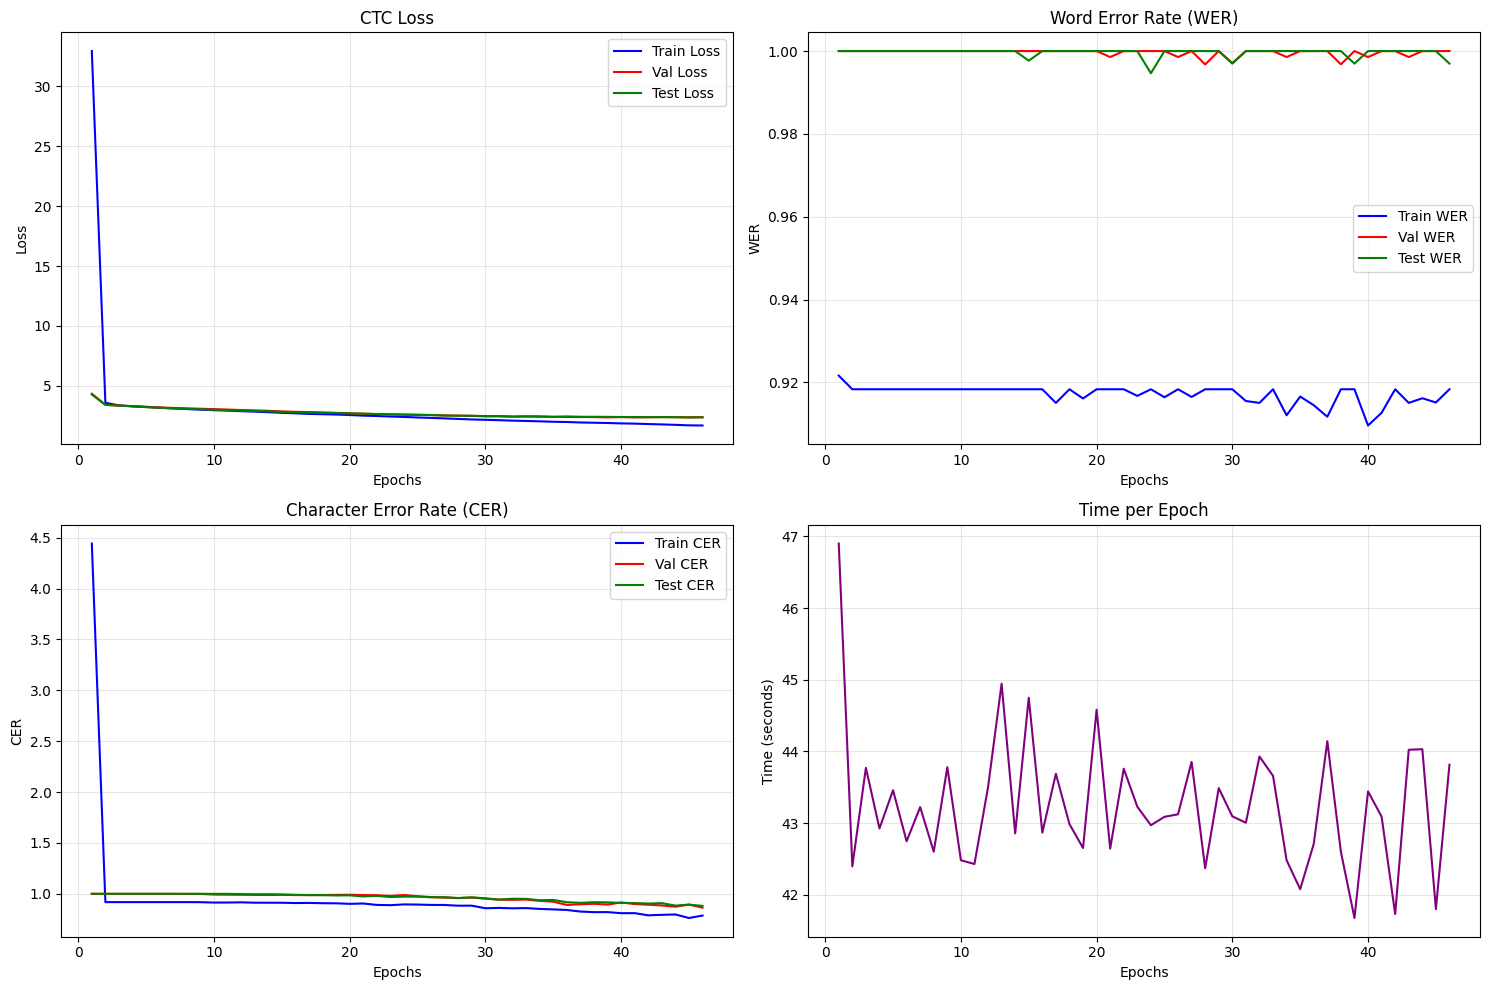

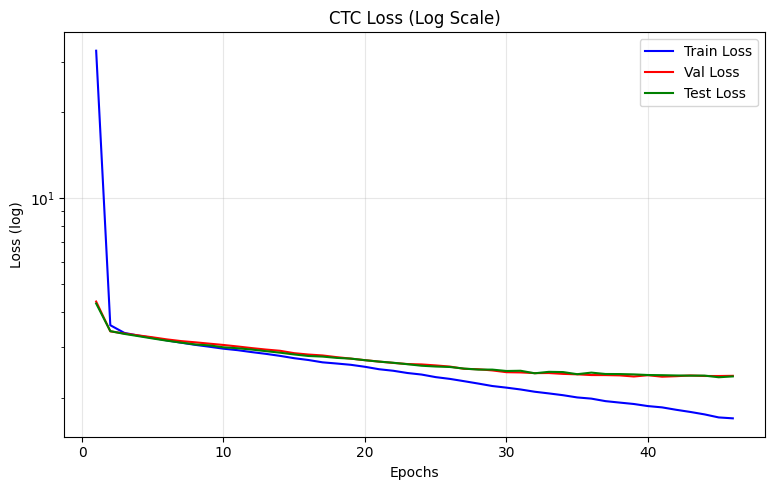

Mel spectrogram shape: torch.Size([1020, 80])
Error processing audio: input.size(-1) must be equal to input_size. Expected 80, got 1020
Example transcription: Error: input.size(-1) must be equal to input_size. Expected 80, got 1020

Example Tokenizer Outputs:
Example 1:
  Target:     'nothing has been done yet to take advantage of the enabling legislation'
  Prediction: 'atttttaaaa asse'
  WER:        1.0000

Example 2:
  Target:     'well he is nearly ninetythree years old'
  Prediction: 'r'
  WER:        1.0000

Example 3:
  Target:     'neat'
  Prediction: 'aatt'
  WER:        1.0000

Example 4:
  Target:     'relax your mouth in its normal position'
  Prediction: ''
  WER:        1.0000

Example 5:
  Target:     'urgent'
  Prediction: ''
  WER:        1.0000

Example 6:
  Target:     'select'
  Prediction: 'ooot'
  WER:        1.0000

Example 7:
  Target:     'at twilight on the twelfth day we'll have chablis'
  Prediction: 'aath'
  WER:        1.0000

Example 8:
  Target:     'sto

In [49]:
# Example usage
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load dataset
    data_dir = '/content/drive/MyDrive/Colab Notebooks/preprocessed_mel/TORGO_mel_preprocessed'
    dataset = PrecomputedMelDataset(data_dir)
    print(f"Dataset size: {len(dataset)} samples")

    # Split dataset
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_ds, val_ds, test_ds = random_split(
        dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)  # For reproducibility
    )

    print(f"Split: {train_size} train, {val_size} validation, {test_size} test")

    # Create data loaders
    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, collate_fn=collate_fn)

    # Create model
    model = CTCTranscriptionTokenizer()
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Train model with early stopping
    history = train_tokenizer(model, train_loader, val_loader, test_loader, device, epochs=100, patience=5)

    # Display metrics in a table
    metrics_df = display_metrics_table(history)

    # Save metrics to CSV
    metrics_df.to_csv('training_metrics.csv', index=False)
    print(f"Metrics saved to training_metrics.csv")

    # Display summary of first 5 and last 5 epochs
    print("\nFirst 5 epochs:")
    display_metrics_table(history, 5)

    print("\nLast 5 epochs:")
    last_5_epochs = min(5, len(history['train_loss']))
    last_5_df = display_metrics_table({
        k: v[-last_5_epochs:] for k, v in history.items() if isinstance(v, list) and len(v) >= last_5_epochs
    })

    # Plot metrics
    plot_training_metrics(history, save_path='training_metrics.png')

    # Load best model for inference example
    model.load_state_dict(torch.load('best_transcription_tokenizer.pt'))

    # Example of tokenizing audio
    audio_path = '/content/drive/MyDrive/Colab Notebooks/TORGO/F/F01/Session1/wav_headMic/0001.wav'
    transcription = tokenize_audio(model, audio_path, device)
    print(f"Example transcription: {transcription}")

    # Save some example outputs for inspection
    example_outputs = []
    model.eval()
    beam_decoder = BeamSearch()

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            if batch is None or i >= 2:  # Just get a few examples
                continue

            specs, targets, spec_lens, target_lens = batch
            specs = specs.to(device)

            logits = model(specs)
            preds = beam_decoder.decode(logits.cpu())

            # Get original targets
            target_texts = []
            target_offset = 0
            for length in target_lens:
                target_slice = targets[target_offset:target_offset + length].tolist()
                target_texts.append(decode_sequence(target_slice))
                target_offset += length

            # Get predictions
            pred_texts = [decode_sequence(pred) for pred in preds]

            # Save some examples
            for j in range(min(5, len(pred_texts))):
                example_outputs.append({
                    'target': target_texts[j],
                    'prediction': pred_texts[j],
                    'wer': wer([target_texts[j]], [pred_texts[j]])
                })

    # Print example outputs
    print("\nExample Tokenizer Outputs:")
    for i, ex in enumerate(example_outputs):
        print(f"Example {i+1}:")
        print(f"  Target:     '{ex['target']}'")
        print(f"  Prediction: '{ex['prediction']}'")
        print(f"  WER:        {ex['wer']:.4f}")
        print()